In [1]:
#The goal of this project is to create a function that can accurately predict future prices of goods and stocks
#I am attempting to do this with a recurrent neural network

In [2]:
#GETTING MY DATA
import csv
R_Goods = [] #(start, end, name)
R_Vals = []
temp = ""
start = 0
end = 0
i=0
with open('data.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        i+=1
        if(row[1]=="Rwanda"): #training on Rwandan food prices (exclusively Rwandan to remain consistant)
            if(temp!=row[7]):
                if(temp!=""):
                    end=i
                    R_Goods.append((start,end,temp))
                start = i
                temp = row[7]
            if(row[15]=="100 KG"):
                R_Vals.append(float(row[16])/float(row[12])/100)
            else:
                R_Vals.append(float(row[16])/float(row[12]))

In [3]:
#IMPORTING THE NN STUFF
from liveplot import create_plot
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    ImportError
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mynn.activations.relu import relu
from mynn.initializers.glorot_normal import glorot_normal
import mygrad as mg
t = np.linspace(0,41266,41266)

In [4]:
#THE MODEL
class Model:
    def __init__(self, C,D,K):
        #Dense layers
        self.dense1 = dense(C,D, weight_initializer=glorot_normal)
        self.dense2 = dense(D,D, weight_initializer=glorot_normal, bias = False)
        self.dense3 = dense(D,K, weight_initializer=glorot_normal)
        self.dim_recurrent = D
    def __call__(self, x):
        h = np.zeros((1,self.dim_recurrent))
        for t in x:
            #Uses the relu function
            h = relu(self.dense1(t)+(self.dense2(h)))
        y = self.dense3(h)
        return y
    @property
    def parameters(self):
        #Returns the parameters to back propogate and get the gradient
        return self.dense1.parameters + self.dense2.parameters + self.dense3.parameters

In [5]:
#PUTTING DATA INTO BATCHES OF CONSISTENT SIZES
x_train = []
y_train = []
x_test = []
y_test = []

R_lens = []
for i in range(len(R_Goods)):
    R_lens.append(R_Goods[i][1]-R_Goods[i][0])
ind = 0
for i in range(len(R_lens)//5*4):
    while(R_lens[i]>=15):
        x_train.append(np.asarray(R_Vals[ind:ind+10]))
        y_train.append(np.asarray(R_Vals[ind+10:ind+15]))
        ind+=15
        R_lens[i]-=15
    ind+=R_lens[i]
    R_lens[i]=0
for i in range(len(R_lens)//5*4,len(R_lens)//5*5):
    while(R_lens[i]>=15):
        x_test.append(np.asarray(R_Vals[ind:ind+10]))
        y_test.append(np.asarray(R_Vals[ind+10:ind+15]))
        ind+=15
        R_lens[i]-=15
    ind+=R_lens[i]
    R_lens[i]=0

In [6]:
y_train[0]

array([43.85, 45.5 , 45.88, 48.2 , 48.5 ])

<IPython.core.display.Javascript object>


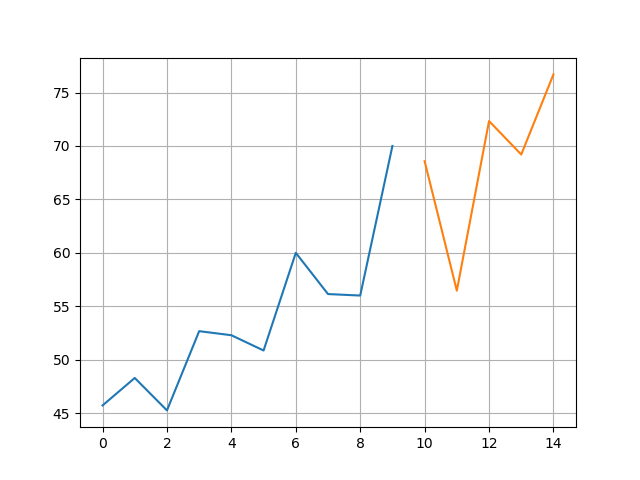

In [7]:
fig, ax = plt.subplots()
ax.plot(t[0:10], x_test[15],marker='')
ax.plot(t[10:15], y_test[15],marker='')
ax.grid()
#BLUE LINE = 10 INPUT VALUES
#ORANGE LINE = 5 EXPECTED OUTPUT VALUES

In [8]:
from mynn.layers.dense import dense
from mynn.initializers.normal import normal
from mynn.optimizers.adam import Adam
from mynn.losses.cross_entropy import softmax_cross_entropy
def accuracy(predictions, truth):
    #The accuracy function is not the standard
    d = 0
    for i in range(predictions.size):
        d += abs(predictions[i]-truth[i])
    return 1-d/(np.sum(predictions)+np.sum(truth))
def l1_loss(pred, true):
    return mg.sum((true - pred)**2) / true.size

In [9]:
mod = Model(10,500,5) #Initializing model with dense layers
#Adam optimizer
optim = Adam(mod.parameters, learning_rate=.1) #Optimizer

<IPython.core.display.Javascript object>


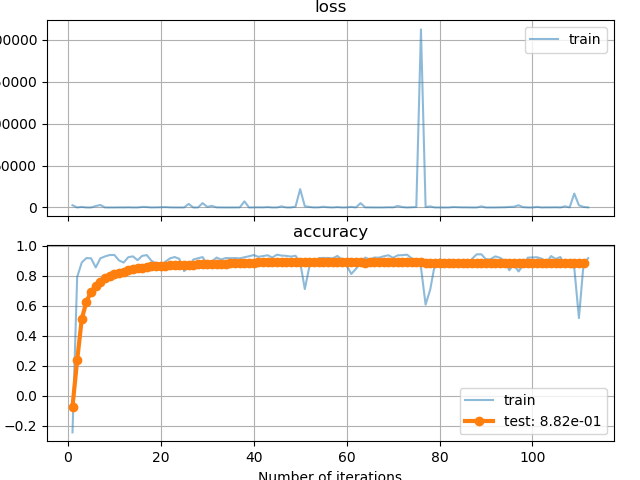

In [10]:
plotter, fig, ax = create_plot(["loss", "accuracy"], refresh=.1);

In [11]:
#This is a live graph of loss and accuracy overtime. One outlier made the scale of the loss graph very large but as a 
#whole is is a downward sloping graph 

In [12]:
#TRAINING THE MODEL
batch_size = 1
optim = Adam(mod.parameters)
a = []
at = []

x_train = np.asarray(x_train).reshape(5578,1,10)
y_train = np.asarray(y_train).reshape(5578,1,5)
x_test = np.asarray(x_test).reshape(982,1,10)
y_test = np.asarray(y_test).reshape(982,1,5)
for epoch_cnt in range(x_train.shape[0]):
    pred = mod(x_train[epoch_cnt])
    true = y_train[epoch_cnt]
    loss = l1_loss(pred,true)
    acc = accuracy(pred.data[0],true[0])
    loss.backward()
    optim.step()
    loss.null_gradients()
    a.append(acc)
    total_acc = np.mean(a)
    if(epoch_cnt%50==0):
        plotter.set_train_batch({"loss":loss.item(), "accuracy":total_acc},
                                    batch_size=1, 
                                    plot=True)
    if(epoch_cnt%50==0):
        for e in range(50):
            
            acc_test = accuracy(mod(x_test[(epoch_cnt*e)%x_test.shape[0]]).data[0],y_test[(epoch_cnt*e)%y_test.shape[0]][0])
            at.append(acc_test)
            total_test_acc = np.mean(np.asarray(at))
            
            plotter.set_test_batch({"accuracy":total_test_acc},
                                    batch_size=1)
        plotter.plot_test_epoch()
    if(epoch_cnt>50):
        a = a[1:]

<IPython.core.display.Javascript object>


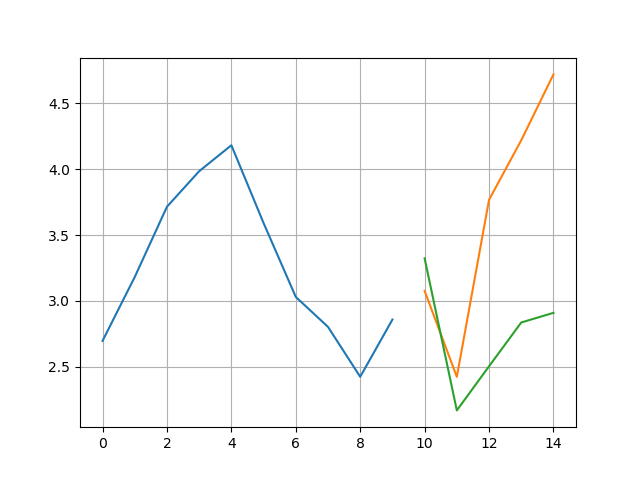

9820


In [13]:
fig, ax = plt.subplots()
print(x_test.size)
ax.plot(t[0:10], x_test[0].reshape(10,),marker='')
ax.plot(t[10:15], y_test[0].reshape(5,),marker='')
ax.plot(t[10:15], mod(x_test[0]).reshape(5,),marker='')
ax.grid()
#GREEN LINE = MODELS PREDICTION

In [14]:
R_Goods = [] #(start, end, name)
temp = ""
start = 0
end = 0
i=0
temp_arr = []
with open('data.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        i+=1
        if(row[1]=="Rwanda"):
            if(temp!=row[7]):
                if(temp!=""):
                    end=i
                    R_Goods.append((temp,temp_arr[-10:]))
                    temp_arr=[]
                start = i
                temp = row[7]
            if(row[15]=="100 KG"):
                temp_arr.append((float(row[16])/float(row[12])/100))
            else:
                temp_arr.append(float(row[16])/float(row[12]))

In [15]:
mod(np.asarray([[13.333333333333334, 16.288886666666667, 15.833333333333334, 14.955553333333334, 14.8, 13.333333333333334, 15.911113333333333, 13.333333333333334, 14.444446666666666, 15.555553333333334]]))

Tensor([[13.30825438, 11.9849767 , 12.04213595, 12.60163297, 13.16184938]])

In [16]:
######################################
#        Trying on S&P 500 data      #
######################################
with open("sp500\data_stocks.txt", 'r') as R:
    a = [i for i in R]
data = []
for i in range(1,41267):
    a[i] = a[i][(a[i].index(","))+1:]
    data.append(float(a[i][0:(a[i].index(","))]))
print(len(data))
t = np.linspace(0,41266,41266)
data = np.asarray(data)
print(type(data))

41266
<class 'numpy.ndarray'>


In [17]:
data -= np.mean(data)
data /= np.std(data) / np.mean(R_Vals)
data -= np.min(data)

<IPython.core.display.Javascript object>


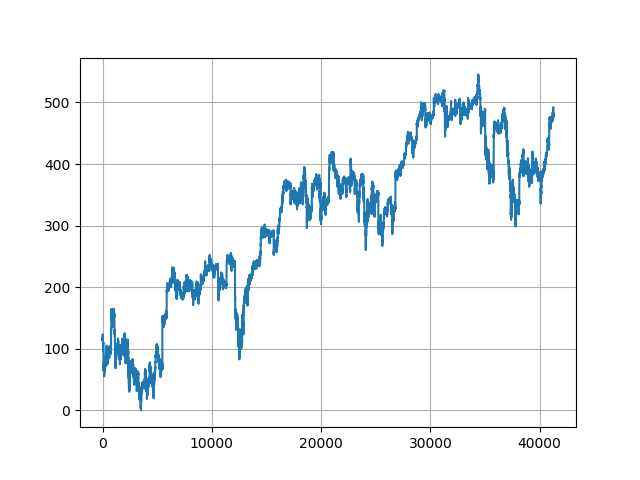

In [18]:
fig, ax = plt.subplots()
ax.plot(t, data,marker='')
ax.grid()

In [19]:
acc = []
i = 0
while(i+15<41266):
    acc.append(accuracy(mod(np.asarray(data[i:i+10]).reshape(1,10)).data[0],data[i+10:i+15]))
    i += 1
print(np.mean(np.asarray(acc)))

0.9705203029400516


In [20]:
#The model did better on the stock data than it did on the food price data.
#This can most likely be attributed to the fact that the food data has a greater variance than the S&P 500 data